In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import utils
import torchvision
from torchvision.io import image
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import time
import numpy as np

In [2]:
content_img_path = Path(r'../data/img/rainier.jpg')
style_img_path = Path(r'../data/img/autumn-oak.jpg')

In [3]:
content_img = Image.open(content_img_path.as_posix())
style_img = Image.open(style_img_path.as_posix())

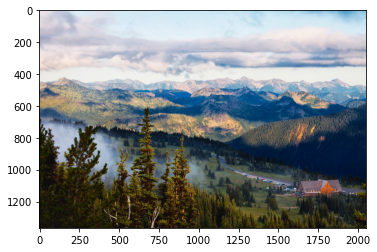

In [4]:
plt.imshow(content_img)

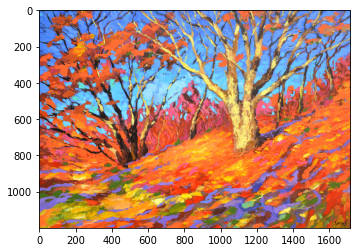

In [5]:
plt.imshow(style_img)

# 预处理和后处理

In [6]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    """
        将像素值范围限制在0~1
    """
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return to_pil_image(img.permute(2, 0, 1))

# 抽取图像特征，vgg19模型

In [7]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

In [8]:
pretrained_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [9]:
# 选择第四卷积块的最后一个卷积层作为内容层，选择每个卷积块的第一个卷积层作为风格层。
# 层次索引
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [10]:
# 构建一个新的网络net，它只保留需要用到的VGG的所有层。（features是别名）
net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)])
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [11]:
def extract_features(X, content_layers, style_layers):
    """
        逐层计算，收集内容层和风格层输出
    """
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [12]:
# 训练时无须改变预训练的VGG的模型参数，提前抽取特征

def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

# 损失函数

In [13]:
# 内容损失
def content_loss(Y_hat, Y):
    """
        内容损失，均方误差
        
        Y_hat: 合成图像的输出
        Y: 内容图像的输出
    """
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

In [14]:
# 风格损失
def gram(X):
    """
        通道间的相关性矩阵
    """
    # 通道数，每个通道元素数（w*h）。X第一维度的批量大小数值为1
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    # X矩阵每一行为一个通道的所有元素
    X = X.reshape((num_channels, n))
    # X矩阵内积，得出通道间的相关性
    # 除以元素数缩放大小
    return torch.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
    """
    计算合成图像和风格图像的gram矩阵的均方误差
    
    Y_hat: 合成图像的输出
    gram_Y: 风格图像的gram矩阵，提前计算得出
    """
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [15]:
# 全变分损失去噪，尽可能使邻近的像素值相似
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [16]:
# 最终的风格转移的损失函数是内容损失、风格损失和总变化损失的加权和
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y_gram) * style_weight for Y_hat, Y_gram in zip(styles_Y_hat, styles_Y_gram)]
    tv_l = [tv_loss(X) * tv_weight]
    # 对所有损失求和
    l = sum(styles_l + contents_l + tv_l)
    return contents_l, styles_l, tv_l, l

# 初始化合成图像

In [17]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [18]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    # 风格图像在各个风格层的格拉姆矩阵styles_Y_gram将在训练前预先计算好
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

# 训练模型

In [19]:
show_imgs = list()

def train(content_X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(content_X, device, lr, styles_Y)    # X为合成图像
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)    # 用合成图像抽取特征
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 20 == 0:
            print(f'epoch: {epoch+1}/{num_epochs} contents_loss: {sum(contents_l):.2f}, styles_loss: {sum(styles_l):.2f}, tv_loss: {sum(tv_l):.2f}')
            show_imgs.append(postprocess(X))
    return X

In [20]:
device = torch.device('cpu')
image_shape = (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 300, 50)

epoch: 20/300 contents_loss: 0.67, styles_loss: 0.42, tv_loss: 3.00
epoch: 40/300 contents_loss: 0.53, styles_loss: 0.41, tv_loss: 2.31
epoch: 60/300 contents_loss: 0.47, styles_loss: 0.35, tv_loss: 1.86
epoch: 80/300 contents_loss: 0.46, styles_loss: 0.37, tv_loss: 1.84
epoch: 100/300 contents_loss: 0.43, styles_loss: 0.36, tv_loss: 1.83
epoch: 120/300 contents_loss: 0.36, styles_loss: 0.33, tv_loss: 1.61
epoch: 140/300 contents_loss: 0.34, styles_loss: 0.32, tv_loss: 1.66
epoch: 160/300 contents_loss: 0.38, styles_loss: 0.32, tv_loss: 1.35
epoch: 180/300 contents_loss: 0.35, styles_loss: 0.32, tv_loss: 1.35
epoch: 200/300 contents_loss: 0.36, styles_loss: 0.31, tv_loss: 1.32
epoch: 220/300 contents_loss: 0.31, styles_loss: 0.31, tv_loss: 1.12
epoch: 240/300 contents_loss: 0.31, styles_loss: 0.32, tv_loss: 1.10
epoch: 260/300 contents_loss: 0.25, styles_loss: 0.30, tv_loss: 0.93
epoch: 280/300 contents_loss: 0.26, styles_loss: 0.32, tv_loss: 0.94
epoch: 300/300 contents_loss: 0.33, st

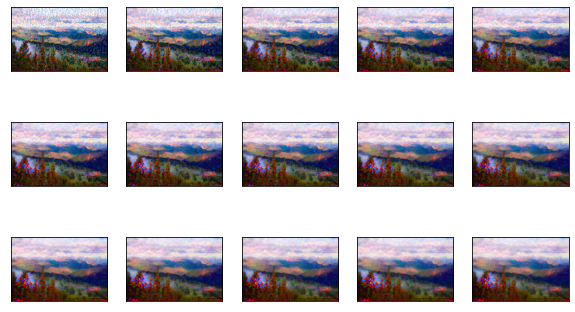

In [21]:
utils.show_images(show_imgs, 3, 5, scale=2);